<a href="https://colab.research.google.com/github/leonardoLavagna/tesla-stock-and-revenues-analysis/blob/main/Tesla_stock_price_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tesla Stock Price Analysis

## Set UP

In [1]:
#!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
 
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Get The Data

In [3]:
Tesla = yf.Ticker('TSLA')

In [4]:
tesla_data = Tesla.history(period = "max")

In [5]:
tesla_data.reset_index(inplace = True)
tesla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0


In [6]:
# Use Web Scraping to get revenue data

url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
html_data = requests.get(url).text

soup = BeautifulSoup(html_data, "html.parser")
soup.find_all('title')


tesla_revenue = pd.DataFrame(columns = ['Date', 'Revenue'])

for row in soup.find_all("tbody")[1].find_all("tr"):
    col = row.find_all("td")
    date = col[0].text
    revenue = col[1].text.replace("$", "").replace(",", "")
    
    tesla_revenue = tesla_revenue.append({"Date": date, "Revenue": revenue}, ignore_index = True)

tesla_revenue.dropna(inplace=True)
tesla_revenue = tesla_revenue[tesla_revenue['Revenue'] != ""]


In [7]:
# check

tesla_revenue.tail()

,Date,Revenue
48,2010-09-30,31
49,2010-06-30,28
50,2010-03-31,21
52,2009-09-30,46
53,2009-06-30,27


In [8]:
# Interactive plots

def make_graph(stock_data, revenue_data, stock):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Historical Share Price", "Historical Revenue"), vertical_spacing = .3)
    fig.add_trace(go.Scatter(x=pd.to_datetime(stock_data.Date, infer_datetime_format=True), y=stock_data.Close.astype("float"), name="Share Price"), row=1, col=1)
    fig.add_trace(go.Scatter(x=pd.to_datetime(revenue_data.Date, infer_datetime_format=True), y=revenue_data.Revenue.astype("float"), name="Revenue"), row=2, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Price ($US)", row=1, col=1)
    fig.update_yaxes(title_text="Revenue ($US Millions)", row=2, col=1)
    fig.update_layout(showlegend=False,
    height=900,
    title=stock,
    xaxis_rangeslider_visible=True)
    fig.show()

In [9]:
make_graph(tesla_data, tesla_revenue, 'Tesla')

## Exploratory data analysis

In [31]:
df = tesla_data

In [12]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3136.000000,3136.000000,3136.000000,3136.000000,3.136000e+03,3136.0,3136.000000
mean,58.487745,59.797971,57.053370,58.453314,9.327497e+07,0.0,0.002551
std,95.698673,97.899054,93.227252,95.583908,8.170407e+07,0.0,0.104109
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06,0.0,0.000000
25%,8.791333,8.969500,8.462667,8.651500,4.213995e+07,0.0,0.000000
50%,16.173333,16.445333,15.899000,16.181667,7.573565e+07,0.0,0.000000
75%,24.291334,24.666668,23.830834,24.196500,1.169441e+08,0.0,0.000000
max,411.470001,414.496674,405.666656,409.970001,9.140820e+08,0.0,5.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          3136 non-null   datetime64[ns, America/New_York]
 1   Open          3136 non-null   float64                         
 2   High          3136 non-null   float64                         
 3   Low           3136 non-null   float64                         
 4   Close         3136 non-null   float64                         
 5   Volume        3136 non-null   int64                           
 6   Dividends     3136 non-null   int64                           
 7   Stock Splits  3136 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5), int64(2)
memory usage: 196.1 KB


In [14]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

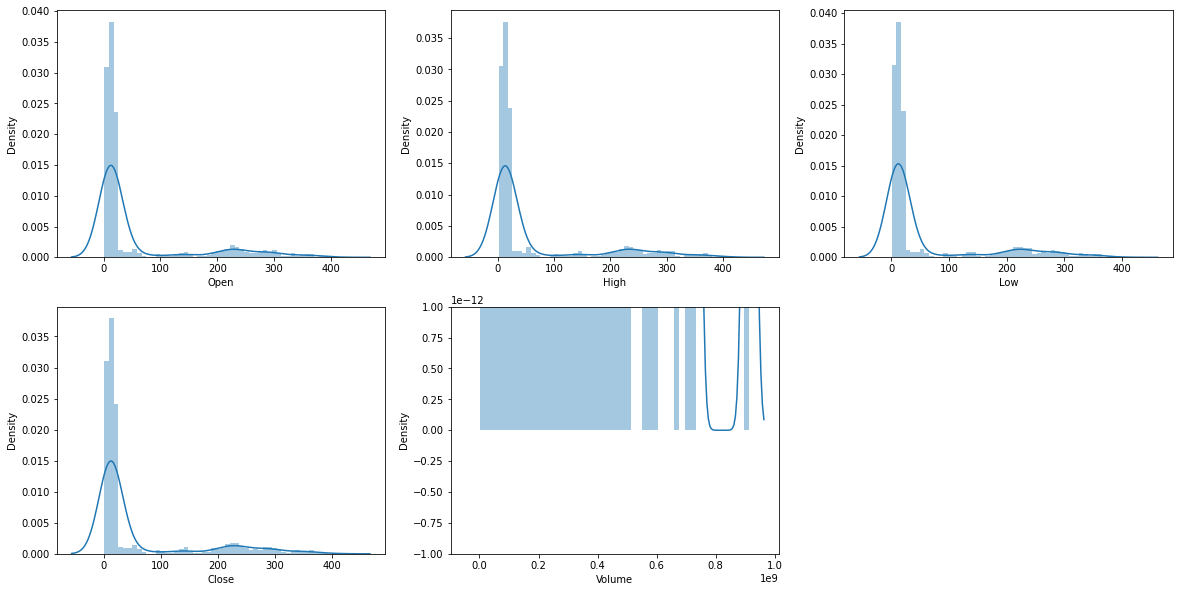

In [15]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

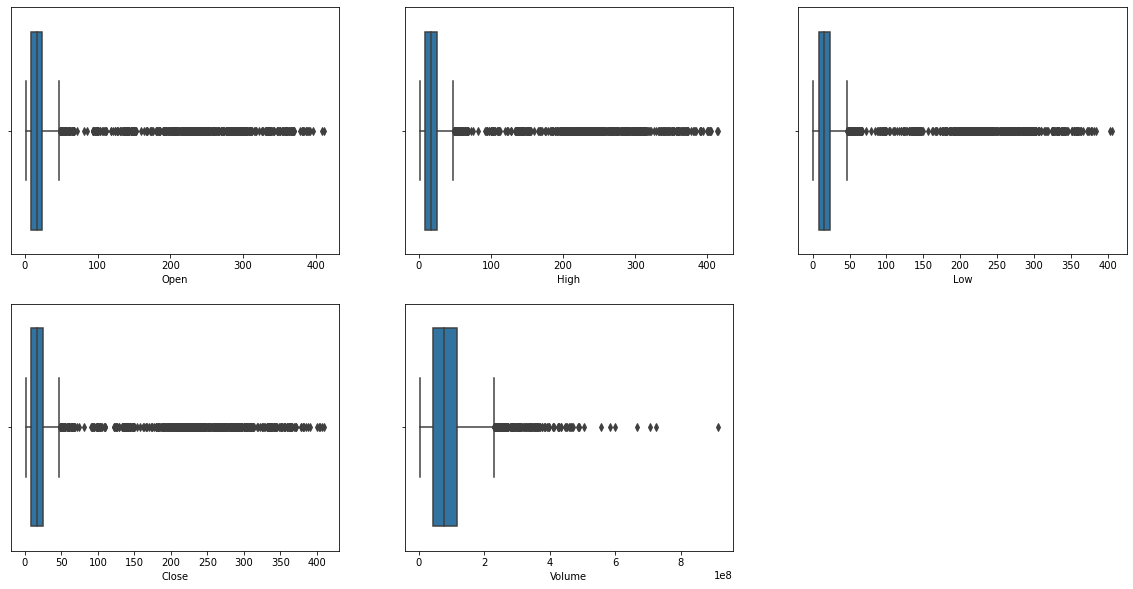

In [16]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

## Feature engineering

In [34]:
splitted = str(df['Date']).split('-')
splitted_y = str(splitted[0]).split(' ')
df['month'] = int(splitted[1])
df['year'] = int(splitted_y[6])
 
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,year,is_quarter_end
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0,6,2010,1
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0,6,2010,1
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0,6,2010,1
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0,6,2010,1
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0,6,2010,1


In [28]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,year,is_quarter_end
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0,6,2010,1
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0,6,2010,1
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0,6,2010,1
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0,6,2010,1
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0,6,2010,1


In [36]:
df.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,year
is_quarter_end,,,,,,,,,
1,58.487745,59.797971,57.05337,58.453314,9.327497e+07,0.0,0.002551,6.0,2010.0


In [37]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

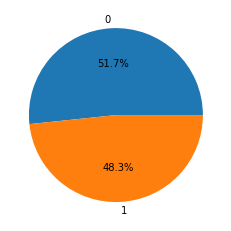

In [38]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

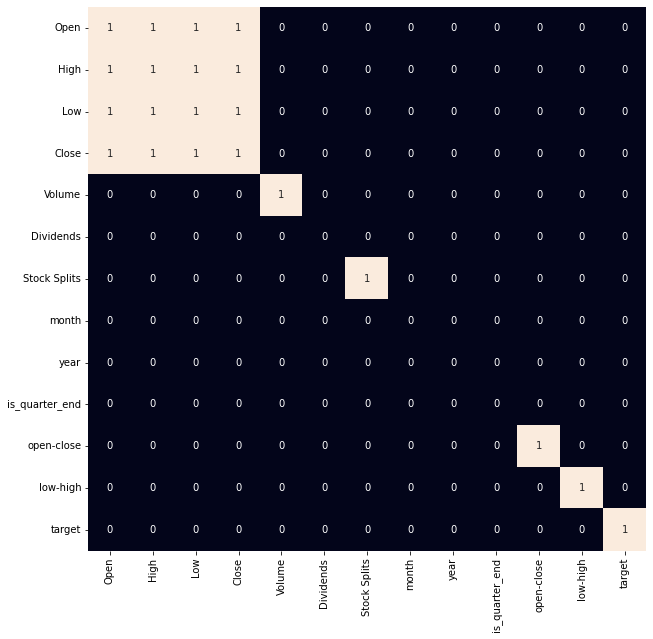

In [39]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

## Model selection, training, testing adn validation

In [40]:
# Data splitting and normalization

features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2822, 3) (314, 3)


In [41]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
 
for i in range(3):
  models[i].fit(X_train, Y_train)
 
  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5091482356489394
Validation Accuracy :  0.5031862745098039

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4926849803960993
Validation Accuracy :  0.43451797385620916

XGBClassifier() : 
Training Accuracy :  0.7015708253744848
Validation Accuracy :  0.5169730392156863



## Conclusion

Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high.


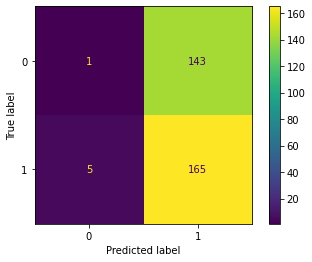

In [43]:
# Confusion matrix for validation data

metrics.plot_confusion_matrix(models[0], X_valid, Y_valid)
plt.show()